# Fashion MNIST

[Fashion-MNIST](https://github.com/zalandoresearch/fashion-mnist) can be used as drop-in replacement for the original MNIST dataset (10 categories of handwritten digits). It shares the same image size (28x28) and structure of training (60,000) and testing (10,000) splits. The class labels are:

| Label|	Description|
|-|-|
|0|	T-shirt/top|
|1|	Trouser|
|2|	Pullover|
|3|	Dress|
|4|	Coat|
|5|	Sandal|
|6|	Shirt|
|7|	Sneaker|
|8|	Bag|
|9|	Ankle boot|

**Example**

<img src="https://github.com/zalandoresearch/fashion-mnist/raw/master/doc/img/fashion-mnist-sprite.png" width="50%"/>

In this notebook, you need to train a classical ML model (no deep learning) to reach the highest accruracy score. Please follow the ML project checklist and make sure you organize your code well.

- **Expected Accuracy Score on the given test set**: >89%
- **Expected Accuracy Score on the HIDDEN test set**: as high as possible. Top 5 will be picked to present

**Submission:** 
- Share your notebook to instructors (quan.tran@coderschool.vn), and prepare your presentation on the next Monday afternoon. 

- The submission.csv file. You can put them inside the submissions folder.
The name of the file should be like this: \<your_name\>_submission.csv. For example: quantran_submission.csv


**Extra optional requirements**:
- Tuning your hyperparameters with both RandomSearch and GridSearch
- Use Sklearn Pipeline (use California House Pricing notebook as an example)
- Confusion Matrix
- Plot the images that the model predicts incorrectly
- Use confusion matrix and images plotted incorrectly to do error analysis

## Sample code to get fashion MNIST data

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

sns.set_style("whitegrid")

In [ ]:
from tensorflow.keras.datasets import fashion_mnist

(X_train, y_train), (X_test, y_test) = fashion_mnist.load_data()

print('Training data:', X_train.shape, y_train.shape)
print('Test data:', X_test.shape, y_test.shape)

4423680/4422102 [==============================] - 0s 0us/step
Training data: (60000, 28, 28) (60000,)
Test data: (10000, 28, 28) (10000,)


In [ ]:
#@title Helper functions {display-mode: "form"}

# This code will be hidden when the notebook is loaded.

# Helper functions
def draw_grid(x_lim=np.array([-4, 4]), y_lim=np.array([-4, 4]), ax=None):
    """Draw an empty grid"""
    ax = ax or plt.gca()
    # Draw ticks and grid
    for i in range(int(x_lim.min()), int(x_lim.max())):
        ax.axvline(i, linestyle='--', color='#ecf0f1', zorder=0)
        ax.plot([i, i], [0.05, -0.05], color='#2c3e50')
    for i in range(int(y_lim.min()), int(y_lim.max())):
        ax.axhline(i, linestyle='--', color='#ecf0f1', zorder=0)
        ax.plot([0.05, -0.05], [i, i], color='#2c3e50')
    # x and y axis
    ax.axhline(0, color='#2c3e50', zorder=0)
    ax.axvline(0, color='#2c3e50', zorder=0)
    ax.scatter([0], [0], color='#c0392b', zorder=0)

    ax.grid(False)
    ax.set_xlim(x_lim)
    ax.set_ylim(y_lim)

def draw_vectors(vectors, origin='origin', cmap=None, labels=None):
    if cmap:
        colors = cmap
    else:
        colors = ['#3498db', '#e67e22', '#f1c40f', '#2ecc71', '#1abc9c']

    if origin == 'origin':
        x_0 = np.zeros(len(vectors))
        y_0 = np.zeros(len(vectors))
    else:
        x_0, y_0 = origin[:, 0], origin[:, 1]
    ax = plt.gca()
    if labels:
        for i in range(len(vectors)):
            ax.text(vectors[i][0]+0.1, vectors[i][1]+0.2, labels[i],
                    {'color': 'black', 'fontsize': 14, 'ha': 'center', 'va': 'center',
                    'bbox': dict(boxstyle="round", fc="white", alpha=0)})
    ax.quiver(x_0, y_0, vectors[:, 0], vectors[:, 1],
              angles='xy', scale_units='xy', scale=1, color=colors)

def projection(x, y, draw_vector=True):
    color = '#95a5a6'
    ax = plt.gca()
    dot_product = np.dot(x, y)
    y_norm = y / np.dot(y, y)
    x_projection = y_norm * dot_product
    ax.plot((x[0], x_projection[0]), (x[1], x_projection[1]), linestyle='--', linewidth=3, c=color)
    if draw_vector:
        draw_vectors(np.array([x_projection]), cmap=['#bdc3c7'])

def determinant_area(i_hat, j_hat):
    ax = plt.gca()
    sum_vector = i_hat + j_hat
    polygon = plt.Polygon([(0, 0), i_hat, sum_vector, j_hat], fill=True, color='#f39c12', alpha=0.3)
    print('Determinant Area:', np.abs(i_hat[0]*j_hat[1] - i_hat[1]*j_hat[0]))
    ax.add_line(polygon)
    
def projection_onto_H(x, w, b):
    ax = plt.gca()
    alpha = (np.dot(x, w) + b) / np.dot(w, w)
    d = alpha * w
    x_projection = x - d
    ax.plot((x[0], x_projection[0]), (x[1], x_projection[1]), linestyle='--', linewidth=3, c='#95a5a6')
    
def plot_margins(X, y, w, b):
    ax = plt.gca()
    gamma = np.abs(np.dot(X, w) + b) / np.sqrt(np.dot(w, w))
    x_pos = X[y==1][np.argmin(gamma[y == 1])]
    x_neg = X[y==0][np.argmin(gamma[y == 0])]
    d_pos = gamma[y==1][np.argmin(gamma[y == 1])]
    d_neg = gamma[y==0][np.argmin(gamma[y == 0])]
    
    ax.scatter([x_pos[0], x_neg[0]],[x_pos[1], x_neg[1]], s=150, linewidth=2, facecolor='none', edgecolors='#2c3e50')
    projection_onto_H(x_pos, w, b)
    projection_onto_H(x_neg, w, b)
    ax.set_title(f'Margin Class +1: {d_pos:.3f}, Class -1: {d_neg:.3f}', fontsize=24)
    
def plot_svc(model, plot_support=True):
    ax = plt.gca()
    xlim = ax.get_xlim() 
    ylim = ax.get_ylim() 
    
    # create grid (coordinate system - x and y) to evaluate model
    x = np.linspace(xlim[0], xlim[1], 40)
    y = np.linspace(ylim[0], ylim[1], 40) 
    X, Y = np.meshgrid(x, y)
    flatten_X = X.ravel() 
    flatten_Y = Y.ravel()
    xy = np.vstack([flatten_X, flatten_Y]).T 
    Z = model.decision_function(xy).reshape(X.shape)

    # Plot decision boundary and margins.
    ax.contour(X, Y, Z, colors='k', # draw filled contours
               levels=[-1, 0, 1], alpha=0.5,
               linestyles=['--', '-', '--'])

    
    # plot circle around the support vectors returned by fitted SVC model
    if plot_support:
        ax.scatter(model.support_vectors_[:, 0], 
                   model.support_vectors_[:, 1],
                   s=150, linewidth=2, facecolors='none', edgecolors='k')
        
def plot_hyperplane(w, b):
    ax = plt.gca()
    draw_vectors(np.array([w]), origin=np.array([[(-b/w[0]), 0]]))
    x_1 = np.linspace(-8, 8, 100)
    ax.plot(x_1, (-w[0]/w[1])*x_1 + (-b/w[1]))

def visualize_classifier(model, X, y, ax=None, cmap='viridis'):
    ax = ax or plt.gca()
    
    # Plot the training points
    # ax.scatter(X[:, 0], X[:, 1], c=y, s=30, cmap=cmap,
    #            clim=(y.min(), y.max()), zorder=3)
    ax.axis('tight')
    xlim = ax.get_xlim()
    ylim = ax.get_ylim()
    
    # fit the estimator
    model.fit(X, y)
    xx, yy = np.meshgrid(np.linspace(*xlim, num=500),
                         np.linspace(*ylim, num=500))
    Z = model.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)

    # Create a color plot with the results
    n_classes = len(np.unique(y))
    contours = ax.contourf(xx, yy, Z, alpha=0.3,
                           levels=np.arange(n_classes + 1) - 0.5,
                           cmap=cmap, clim=(y.min(), y.max()),
                           zorder=1)

    ax.set(xlim=xlim, ylim=ylim)

def plot_classifier_with_2d_data(clf, X, y, ax=None, title='', cmap='viridis'):
    ax = ax or plt.gca()

    ax.scatter(X[:, 0], X[:, 1], c=y, s=30, cmap=cmap,
               clim=(y.min(), y.max()), zorder=3)

    visualize_classifier(clf, X, y, ax=ax)

    ax.set_title(title)
    ax.set_xlabel(r'$x_1$', fontsize=20)
    ax.set_ylabel(r'$x_2$', fontsize=20)

def split_data(data):
    
    X = data.drop('Class', axis=1)
    y = data['Class']

    # Train-Test slpit of 70%-30%
    X_train, X_test, y_train, y_test = train_test_split(X.values, y.values, test_size=0.3, stratify=y, random_state=102)

    return (X_train, X_test, y_train, y_test)

def base_learners_evaluations(data):
    X_train, X_test, y_train, y_test = data
    
    idx = []
    scores = {'F1 score': [], 'Recall':[]}
    for bc in base_classifiers:
        lr = bc[1]
        lr.fit(X_train, y_train)

        predictions = lr.predict(X_test)

        idx.append(bc[0])
        scores['F1 score'].append(metrics.f1_score(y_test, predictions))
        scores['Recall'].append(metrics.recall_score(y_test, predictions))

    return pd.DataFrame(data=scores, index=idx)

def ensemble_evaluation(data, model, label='Original'):
    #X_train, X_test, y_train, y_test = split_data(data)
    X_train, X_test, y_train, y_test = data
    model.fit(X_train, y_train)
    predictions = model.predict(X_test)       
    return pd.DataFrame({'F1 Score': [metrics.f1_score(y_test, predictions)],
                         'Recall': [metrics.recall_score(y_test, predictions)]}, index=[label])
    
def plot_models_comparison(title='F1 Score'):
    labels = models_comparison.keys()
    original_data = [models_comparison[model][title]['Original'] for model in labels]
    filtered_data = [models_comparison[model][title]['Filtered'] for model in labels]

    best_score_each_model = [max(original_data[i], filtered_data[i]) for i in range(len(original_data))]
    labels = [x for _, x in sorted(zip(best_score_each_model, labels), key=lambda pair: pair[0])]
    original_data = [x for _, x in sorted(zip(best_score_each_model, original_data), key=lambda pair: pair[0])]
    filtered_data = [x for _, x in sorted(zip(best_score_each_model, filtered_data), key=lambda pair: pair[0])]

    x = np.arange(len(labels))  # the label locations
    width = 0.35  # the width of the bars

    fig, ax = plt.subplots(figsize=(8,8))
    rects1 = ax.bar(x - width/2, original_data, width, label='Original Data')
    rects2 = ax.bar(x + width/2, filtered_data, width, label='Filtered Data')

    # Add some text for labels, title and custom x-axis tick labels, etc.
    ax.set_ylabel('Scores')
    ax.set_title(title)
    ax.set_xticks(x)
    ax.set_xticklabels(labels)
    ax.legend()

    def autolabel(rects):
        """Attach a text label above each bar in *rects*, displaying its height."""
        for rect in rects:
            height = rect.get_height()
            ax.annotate('{0:.3f}'.format(height),
                        xy=(rect.get_x() + rect.get_width() / 2, height),
                        xytext=(0, 3),  # 3 points vertical offset
                        textcoords="offset points",
                        ha='center', va='bottom')

    autolabel(rects1)
    autolabel(rects2)

    fig.tight_layout()

    plt.show()

# Sample code to display images

In [ ]:
X_train[3].shape, y_train[3]

((28, 28), 3)

In [ ]:
X_train[3]

array([[  0,   0,   0,   0,   0,   0,   0,   0,  33,  96, 175, 156,  64,
         14,  54, 137, 204, 194, 102,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,  73, 186, 177, 183, 175, 188, 232,
        255, 223, 219, 194, 179, 186, 213, 146,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,  35, 163, 140, 150, 152, 150, 146, 175,
        175, 173, 171, 156, 152, 148, 129, 156, 140,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0, 150, 142, 140, 152, 160, 156, 146, 142,
        127, 135, 133, 140, 140, 137, 133, 125, 169,  75,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,  54, 167, 146, 129, 142, 137, 137, 131,
        148, 148, 133, 131, 131, 131, 125, 140, 140,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0, 110, 188, 133, 146, 152, 133, 125,
        127, 119, 129, 133, 119, 140, 131, 150,  14,   0,   0,   0,   0,
          0,   0],
       [  

Label: 3


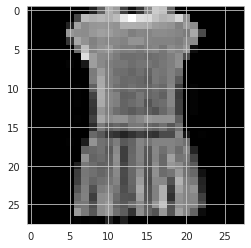

In [ ]:
print('Label:', y_train[3])
plt.imshow(X_train[3], cmap='gray')

In [ ]:
def plot_images(images, labels=None):
  '''Plot images with their labels. Ten each row'''
  plt.figure(figsize=(20,20))
  columns = 10
  for i, image in enumerate(images):
    ax = plt.subplot(len(images) / columns + 1, columns, i + 1)
    if not labels is None:
      ax.set_title(f"{labels[i]}", fontsize=16)
    plt.axis('off')
    plt.subplots_adjust(bottom=0.1)
    plt.imshow(image, cmap='gray')

In [ ]:
def get_samples(n_samples, X, y=None):
  '''Get n_samples randomly'''
  samples_index = np.random.choice(np.arange(len(X)), n_samples, replace=False)
  if not y is None:
    return X[samples_index], y[samples_index]
  return X[samples_index]

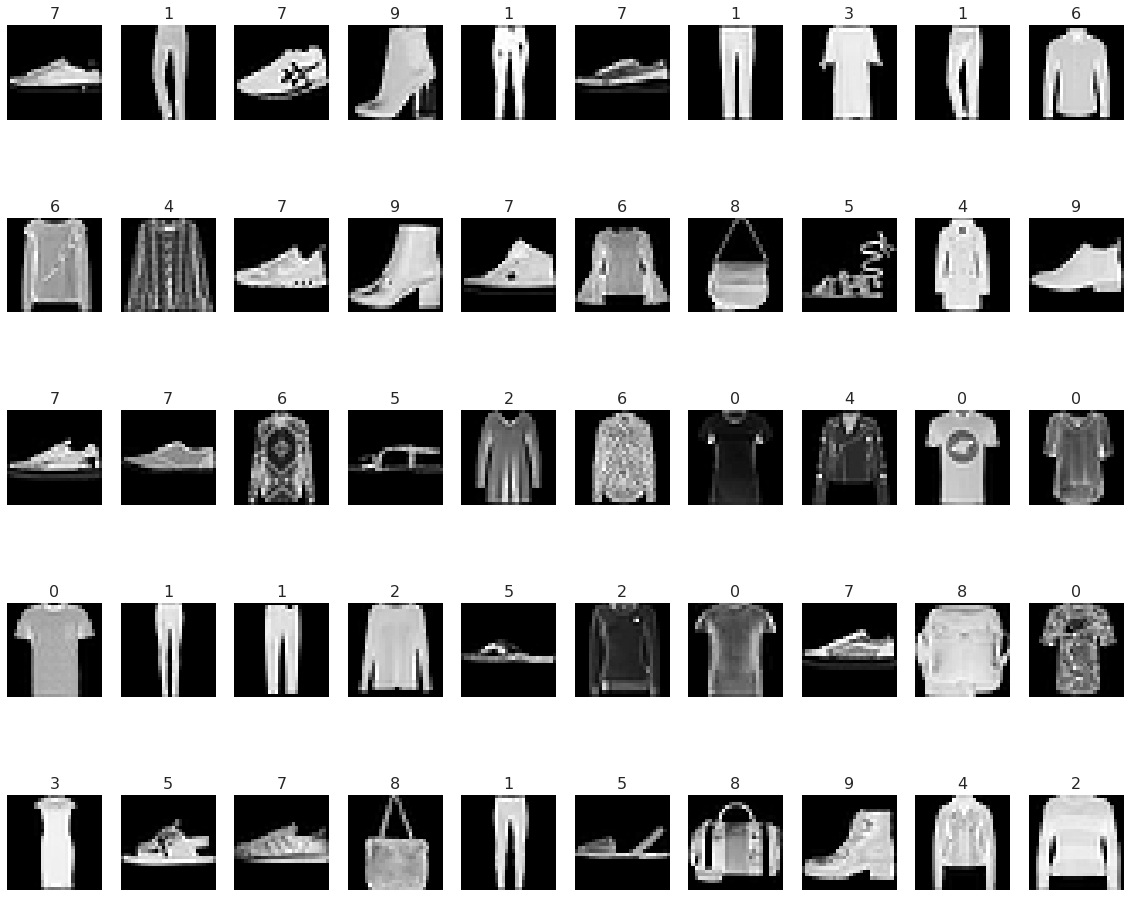

In [ ]:
images, labels = get_samples(50, X_train, y_train)
plot_images(images, labels)

# Your Code 

These are numpy arrays:
- X_train 
- y_train 
- X_test 
- y_test

In [ ]:
print('Trainingm data:', X_train.shape, y_train.shape)
print('Test data:', X_test.shape, y_test.shape)

Trainingm data: (60000, 28, 28) (60000,)
Test data: (10000, 28, 28) (10000,)


Check the distribution of labels in both train and test. Looks balance!

In [ ]:
print('unique values in y_train:', np.unique(y_train, return_counts=True) )
print('unique values in y_test:', np.unique(y_test, return_counts=True) )

unique values in y_train: (array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8), array([6000, 6000, 6000, 6000, 6000, 6000, 6000, 6000, 6000, 6000]))
unique values in y_test: (array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8), array([1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000]))


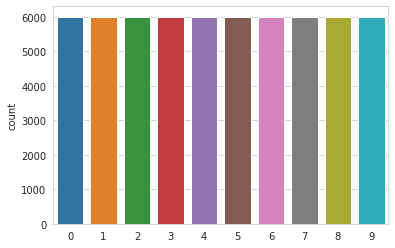

In [ ]:
sns.countplot(y_train)

#### Pre-process data:
- Scale pixel values
- Augment the data: rotate the images, shift the images
- Flatten the 2D array --> 1D vector


In [ ]:
X_train[3][0].shape

(28,)

In [ ]:
n_samples = 4000
n_test_samples = 800
X_train_flat, y_train_flat = get_samples(n_samples, X_train, y_train)
X_test_flat, y_test_flat = get_samples(n_test_samples, X_test, y_test)
print('Original shape:', X_train_flat.shape,X_test_flat.shape)
# Normalization
X_train_flat = X_train_flat.reshape((n_samples, -1))/255
X_test_flat = X_test_flat.reshape((n_test_samples, -1))/255

print('Training data', X_train_flat.shape)
print('Test data', X_test_flat.shape)

Original shape: (4000, 28, 28) (800, 28, 28)
Training data (4000, 784)
Test data (800, 784)


#### Model training:
- Linear SVM and Kernel SVM
- Decision Tree
- Random Forest
- Boosting \& Bagging

In [ ]:
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, accuracy_score, make_scorer
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

In [ ]:
model_SVC = SVC(C=3)

model_SVC.fit(X_train_flat, y_train_flat)
y_pred = model_SVC.predict(X_test_flat)

In [ ]:
print("Accuracy:", accuracy_score(y_test_flat, y_pred))

Accuracy: 0.8575


<Figure size 1440x1440 with 0 Axes>

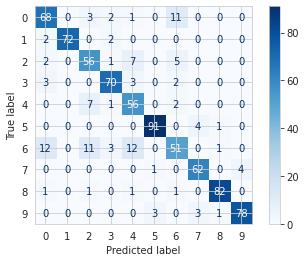

In [ ]:
from sklearn.metrics import plot_confusion_matrix
plt.figure(figsize=(20,20))
plot_confusion_matrix(model_SVC, X_test_flat, y_test_flat,
                                 cmap=plt.cm.Blues)

In [ ]:
# # Use RandomizedSearchCV
# from sklearn.model_selection import RandomizedSearchCV

# parameters = {'gamma': np.arange(0.001, 10, 0.1),
#               'C': np.arange(0.001, 10, 0.1)}

# model = SVC(kernel='rbf')

# random_models = RandomizedSearchCV(estimator=model,
#                                    param_distributions=parameters,
#                                    n_iter=50,
#                                    scoring=make_scorer(accuracy_score),
#                                    cv=5, n_jobs=-1)
# random_models.fit(X_train_flat, y_train_flat)


In [ ]:
#random_models.best_params_

In [ ]:
#random_models.best_score_

In [ ]:
# best_svm_model = random_models.best_estimator_
# svm_predictions = best_svm_model.predict(X_test_flat) # predictions on test set
# print('Accuracy Score:', accuracy_score(y_test_flat, svm_predictions))

In [ ]:
from sklearn.tree import DecisionTreeClassifier

In [ ]:
model_tree = DecisionTreeClassifier(max_depth=10, min_samples_leaf = 8,criterion='gini').fit(X_train_flat, y_train_flat)
accuracy_score(y_test_flat, model_tree.predict(X_test_flat) )

0.725

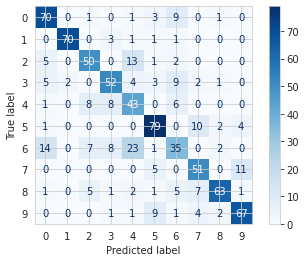

In [ ]:
plot_confusion_matrix(model_tree, X_test_flat, y_test_flat,
                                 cmap=plt.cm.Blues)

In [ ]:
# # USE THIS CELL TO TEST THE MIN_SAMPLES_LEAF OR MAX_DEPTH
# train_errors = []
# test_errors = []
# a_range = np.arange(2, 40)
# for i in a_range:
#     model_tree = DecisionTreeClassifier(max_depth=i, min_samples_leaf=8, criterion='gini').fit(X_train_flat, y_train_flat)
#     train_errors.append(1 - accuracy_score(y_train_flat, model_tree.predict(X_train_flat)))
#     test_errors.append(1 - accuracy_score(y_test_flat, model_tree.predict(X_test_flat)))

# plt.figure(figsize=(16, 9))
# plt.scatter(a_range, train_errors)
# plt.plot(a_range, train_errors, label='Training Error')
# plt.scatter(a_range, test_errors)
# plt.plot(a_range, test_errors, label='Test Error')
# plt.legend()
# plt.title('Decision Tree - Overfitting & Underfitting')
# plt.xlabel('Min sample leaf', fontsize=16)
# plt.ylabel('Error in %', fontsize=16)
# plt.show()

In [ ]:
from sklearn.ensemble import RandomForestClassifier

model_rf = RandomForestClassifier(n_estimators=40, max_depth=10, min_samples_leaf=8)
model_rf.fit(X_train_flat, y_train_flat)
accuracy_score(y_test_flat, model_rf.predict(X_test_flat) )

0.8025

In [ ]:
model_rf = RandomForestClassifier(n_estimators=40, max_depth=10, min_samples_leaf=8)
scores = cross_val_score(model_rf, X_train_flat, y_train_flat, cv=5)
scores

array([0.83125, 0.8125 , 0.83   , 0.8225 , 0.83125])

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import VotingClassifier
from sklearn import metrics

# Base learners
voting_classifiers = VotingClassifier( estimators=[('SVC', SVC(C=3)),
                    ('Decision Tree 10', DecisionTreeClassifier(max_depth=10, min_samples_leaf = 8,criterion='gini')),
                    ('RF', RandomForestClassifier(n_estimators=40, max_depth=10, min_samples_leaf=8)),
                    ('Logistic Regression', LogisticRegression(max_iter=2000))],
                      voting='hard')
voting_classifiers.fit(X_train_flat, y_train_flat)
accuracy_score(y_test_flat, voting_classifiers.predict(X_test_flat) )

0.8375

In [ ]:
from sklearn.ensemble import AdaBoostClassifier

model_adaboost = AdaBoostClassifier(n_estimators=200)
model_adaboost.fit(X_train_flat, y_train_flat)
accuracy_score(y_test_flat, model_adaboost.predict(X_test_flat) )


0.36875

In [ ]:
%%time
from xgboost import XGBClassifier

model_xgboost = XGBClassifier(tree_method='gpu_hist', predictor='gpu_predictor', max_depth=10)
model_xgboost.fit(X_train_flat, y_train_flat)
print(accuracy_score(y_test_flat, model_xgboost.predict(X_test_flat) ))


0.8325
CPU times: user 12.4 s, sys: 7.11 s, total: 19.5 s
Wall time: 19.5 s


# Test set

Here is the test set without label (FMNIST_augmented_test.npy). You will use your trained machine learning model to make predictions on this test set, and then submit a csv file containing the predictions 

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
PATH = '/content/gdrive/MyDrive/FTMLE | 2020.11 | Izu/Week_6/Weekly_Project/'

In [ ]:
X_test_augmented = np.load(PATH + 'FMNIST_augmented_test.npy')

In [ ]:
X_test_augmented.shape

(40000, 28, 28)

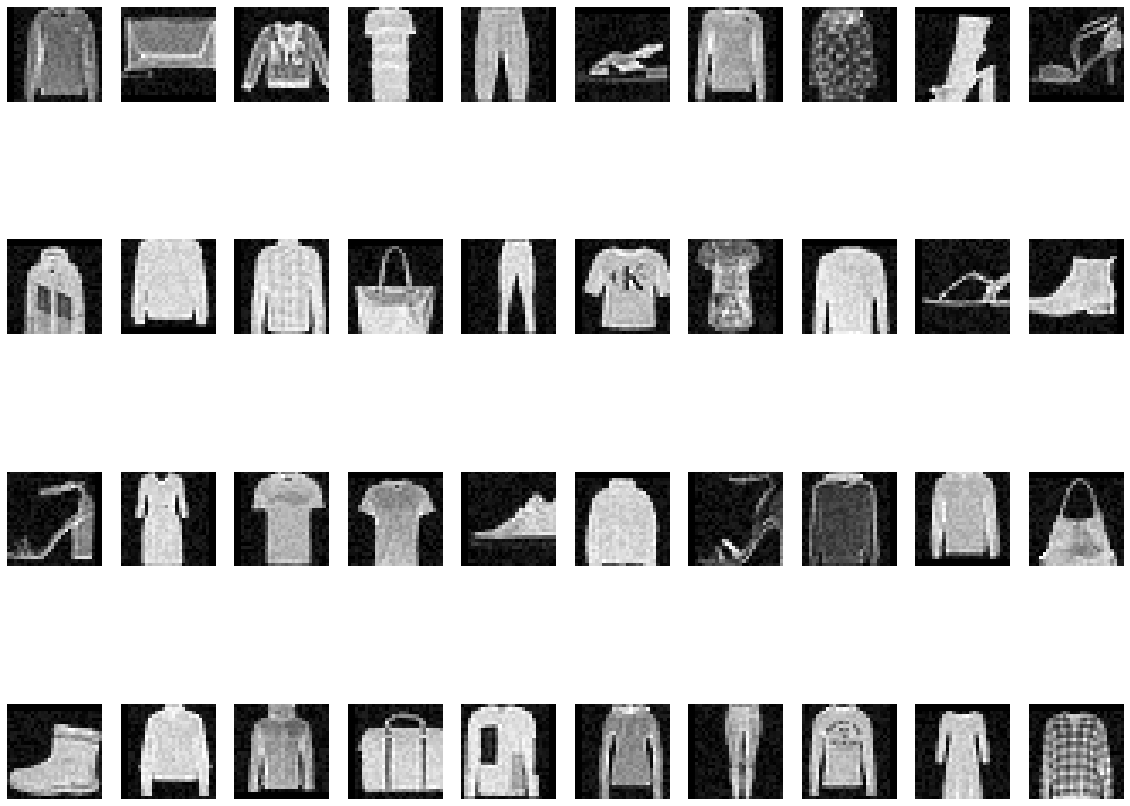

In [ ]:
images = get_samples(40, X_test_augmented)
plot_images(images)

Note: pay close attention to this test set. This test set is slightly different from the train set. In order to improve your model, make sure you know what the difference is so that you can perform appropriate processings.

** From my observation, the images in the test set are not centered and kind of shifting around a few pixels **

# Submit your predictions as csv file

In [ ]:
# let's make a silly prediction that every image is T-shirt, meaning every prediction is 0
# Here is how you can make such prediction
predictions = np.zeros(shape=[len(X_test_augmented),]).astype(int)

In [ ]:
predictions.shape # make sure that you have 40000 predictions, since the hidden test set has 40000 images

(40000,)

In [ ]:
pred_df = pd.DataFrame(predictions,columns=['pred'])
pred_df.head()

,pred
0,0
1,0
2,0
3,0
4,0


In [ ]:
MY_NAME='quantran'
pred_df.to_csv(PATH + f"/submissions/{MY_NAME}_submission.csv", index=None)

By running the cell above, you actually submit your predictions directly to the submissions folder in Weekly_Project folder, as I have granted you permission to save files there. Let me know if you have any problem running the cell above.



Good luck!